In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import os

# --- Step 0: Data Simulation (for demonstration purposes) ---
# In your actual project, you would have separate CSV files.
# This section creates dummy data to make the script runnable.

def create_dummy_data():
    """Creates dummy CPI and IIP data files for demonstration."""
    print("Creating dummy data files: cpi_data.csv and iip_data.csv...")

    # Create a date range
    dates = pd.date_range(start='2010-01-01', end='2023-12-31', freq='MS')

    # Simulate CPI data (Consumer Price Index) with a trend
    cpi_values = 100 + np.arange(len(dates)) * 0.5 + np.random.randn(len(dates)) * 2
    cpi_df = pd.DataFrame({'Date': dates, 'CPI': cpi_values})
    # Introduce a missing value
    cpi_df.loc[cpi_df.sample(1).index, 'CPI'] = np.nan
    cpi_df.to_csv('cpi_data.csv', index=False)

    # Simulate IIP data (Index of Industrial Production) with seasonality and trend
    iip_values = 100 + np.sin(np.arange(len(dates)) * (np.pi/6)) * 5 + np.arange(len(dates)) * 0.3 + np.random.randn(len(dates))
    iip_df = pd.DataFrame({'Date': dates, 'IIP': iip_values})
    # Introduce a missing value
    iip_df.loc[iip_df.sample(1).index, 'IIP'] = np.nan
    iip_df.to_csv('iip_data.csv', index=False)

    print("Dummy data created successfully.\n")

# Run the data creation function
create_dummy_data()


# --- B. Data Wrangling and Pre-processing ---

# 1. Assemble the Dataset
print("--- 1. Assembling the Dataset ---")
try:
    cpi_df = pd.read_csv('cpi_data.csv')
    iip_df = pd.read_csv('iip_data.csv')

    # Convert 'Date' column to datetime objects
    cpi_df['Date'] = pd.to_datetime(cpi_df['Date'])
    iip_df['Date'] = pd.to_datetime(iip_df['Date'])

    # Merge DataFrames on the 'Date' column
    df = pd.merge(cpi_df, iip_df, on='Date', how='outer')

    # Set 'Date' as the index
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

    print("Initial dataset assembled:")
    print(df.head())
    print("\nDataset Info:")
    df.info()

except FileNotFoundError:
    print("Error: Make sure 'cpi_data.csv' and 'iip_data.csv' are in the same directory.")
    exit()


# 2. Handle Missing Values
print("\n--- 2. Handling Missing Values ---")
print(f"Number of missing values before handling:\n{df.isnull().sum()}")

# Apply forward-fill to propagate the last valid observation
df.fillna(method='ffill', inplace=True)

print(f"\nNumber of missing values after forward-fill:\n{df.isnull().sum()}")


# 3. Feature Transformation
print("\n--- 3. Transforming Features ---")

# Calculate Year-on-Year (YoY) Headline Inflation (Target Variable)
# Formula: ((CPI_current_month / CPI_same_month_previous_year) - 1) * 100
# This is equivalent to comparing with the value from 12 months ago
df['Inflation_YoY'] = df['CPI'].pct_change(periods=12) * 100

# Calculate Year-on-Year (YoY) IIP Growth
df['IIP_Growth_YoY'] = df['IIP'].pct_change(periods=12) * 100

# The first 12 rows will have NaN values due to the YoY calculation. Let's drop them.
print(f"\nShape before dropping NaN from YoY calculation: {df.shape}")
df.dropna(inplace=True)
print(f"Shape after dropping NaN from YoY calculation: {df.shape}")

print("\nDataset after feature transformation:")
print(df[['Inflation_YoY', 'IIP_Growth_YoY']].head())


# 4. Check for Stationarity
print("\n--- 4. Checking for Stationarity using Augmented Dickey-Fuller (ADF) Test ---")

def perform_adf_test(series, name):
    """
    Performs the ADF test on a time series and prints the results.
    """
    print(f"\nADF Test for: '{name}'")
    # The adfuller function returns a tuple of statistics
    result = adfuller(series.dropna())

    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')

    # Check the p-value against a significance level (e.g., 0.05)
    if result[1] <= 0.05:
        print(f"Conclusion: The p-value is less than or equal to 0.05. We reject the null hypothesis.")
        print(f"The '{name}' series is likely stationary.")
    else:
        print(f"Conclusion: The p-value is greater than 0.05. We fail to reject the null hypothesis.")
        print(f"The '{name}' series is likely non-stationary.")

# Test the transformed variables for stationarity
perform_adf_test(df['Inflation_YoY'], 'YoY Headline Inflation')
perform_adf_test(df['IIP_Growth_YoY'], 'YoY IIP Growth')


# Example of differencing if a series were non-stationary
# Let's test the original 'CPI' series, which is non-stationary by design
print("\n--- Example: Handling a Non-Stationary Series ---")
perform_adf_test(df['CPI'], 'Original CPI Index (Expected Non-Stationary)')

# Apply first-order differencing
df['CPI_diff_1'] = df['CPI'].diff(1)
perform_adf_test(df['CPI_diff_1'].dropna(), 'First-Differenced CPI Index')

print("\nFinal pre-processed DataFrame ready for modeling:")
print(df.head())

# Clean up dummy files
os.remove('cpi_data.csv')
os.remove('iip_data.csv')

Creating dummy data files: cpi_data.csv and iip_data.csv...
Dummy data created successfully.

--- 1. Assembling the Dataset ---
Initial dataset assembled:
                   CPI         IIP
Date                              
2010-01-01  101.338208   98.711043
2010-02-01   99.504531  101.961560
2010-03-01  100.719906  104.111518
2010-04-01  100.876332  106.404943
2010-05-01  104.525360  105.309539

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2010-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     167 non-null    float64
 1   IIP     167 non-null    float64
dtypes: float64(2)
memory usage: 3.9 KB

--- 2. Handling Missing Values ---
Number of missing values before handling:
CPI    1
IIP    1
dtype: int64

Number of missing values after forward-fill:
CPI    0
IIP    0
dtype: int64

--- 3. Transforming Features ---

Shape before dropping NaN from YoY calculation: (168,

/tmp/ipython-input-4084916882.py:71: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Creating dummy data files for demonstration purposes...
Dummy data created successfully.

--- Phase 1: Loading and Pre-processing Data ---
Data successfully merged.
Data pre-processing complete.
Final DataFrame head:
            Inflation_YoY  IIP_Growth_YoY  Repo_Rate    USD_INR  POILBREUSDM
Date                                                                        
2012-02-01      -1.763677        3.347461   7.942389  54.233306   109.569048
2012-03-01      -0.749018        4.480641   7.796256  55.252182   109.569048
2012-04-01       0.035038        2.217626   8.094005  56.803461   109.569048
2012-05-01       0.684642        5.534563   8.122526  57.560002   109.569048
2012-06-01       0.625634        2.675877   7.931271  57.702936   109.569048

--- Phase 2: Starting Exploratory Data Analysis ---

1. Generating Time Series Plots for each variable...


/tmp/ipython-input-495528243.py:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


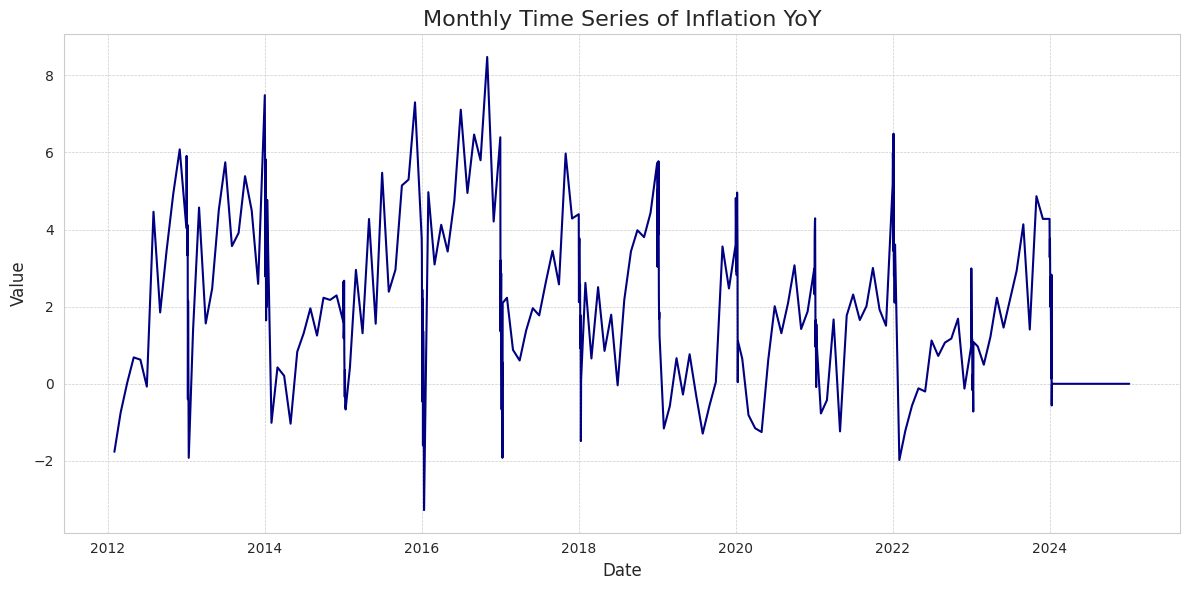

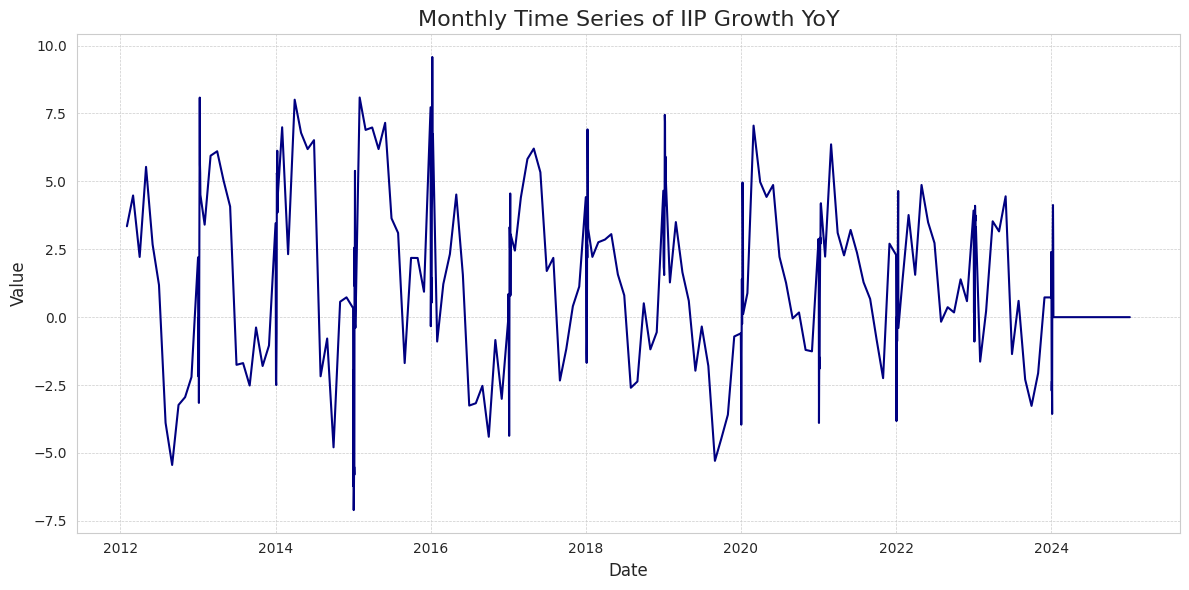

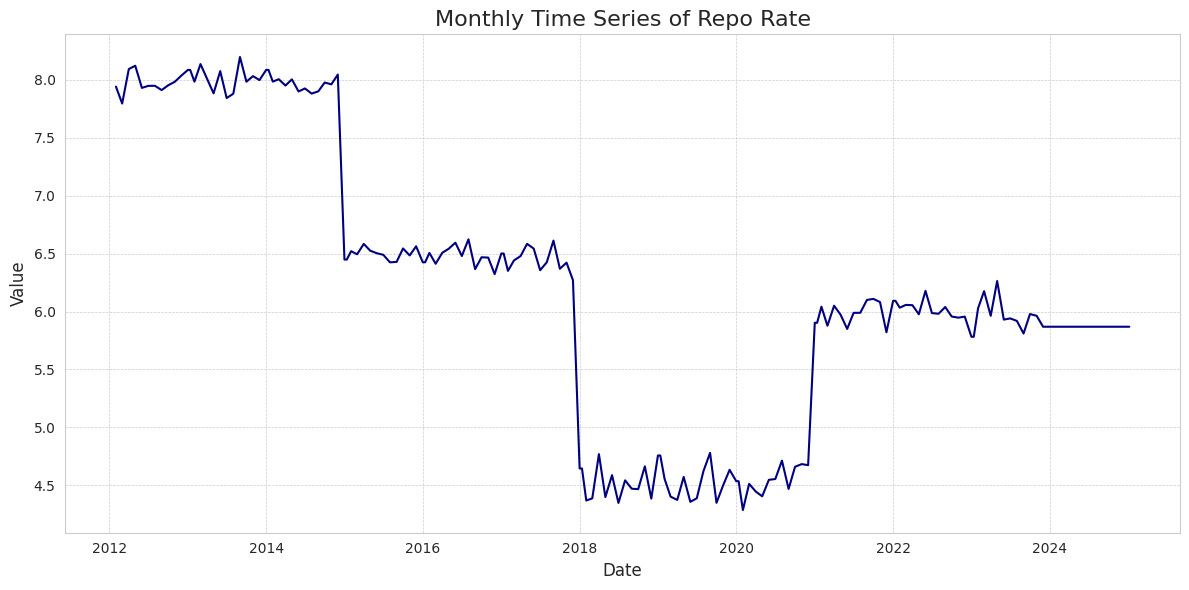

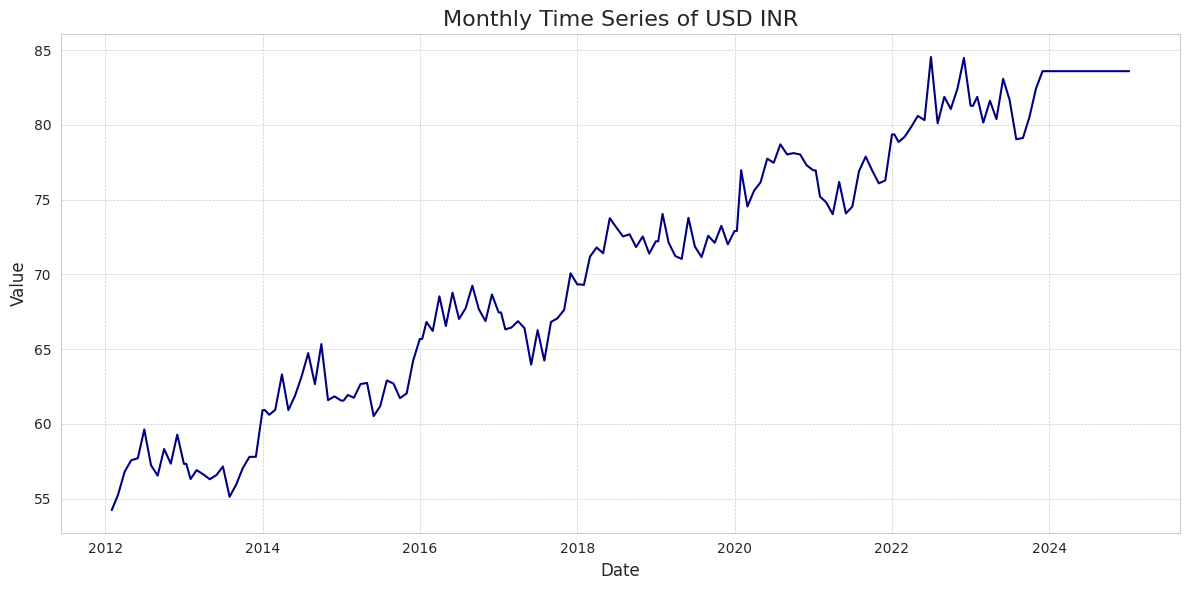

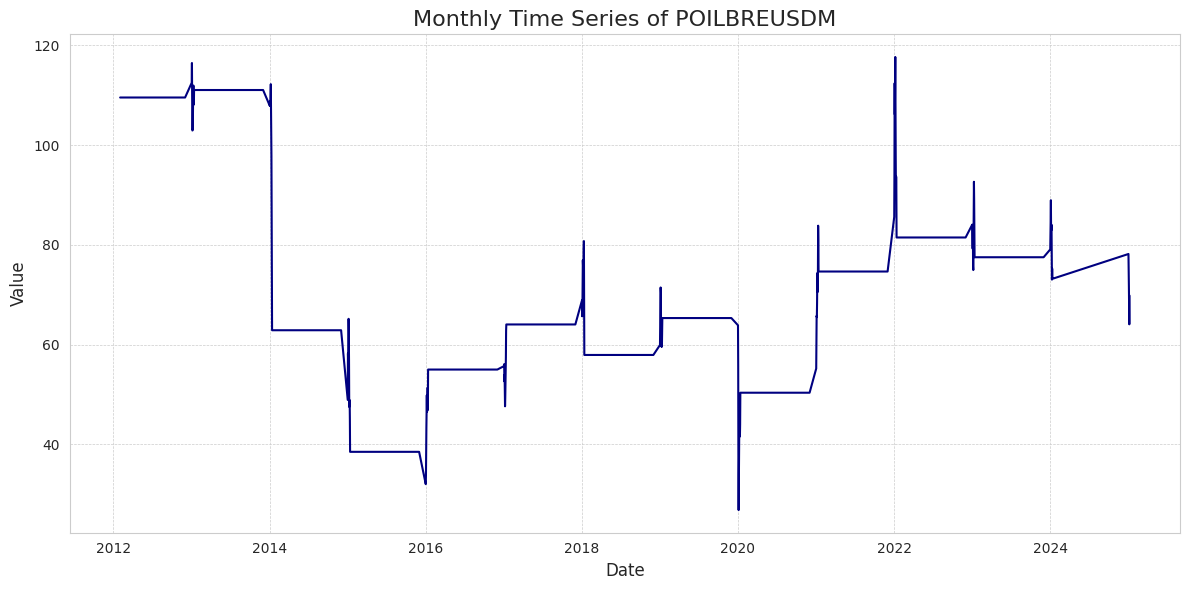

Time series plots displayed.

2. Generating Decomposition Plot for Headline Inflation...


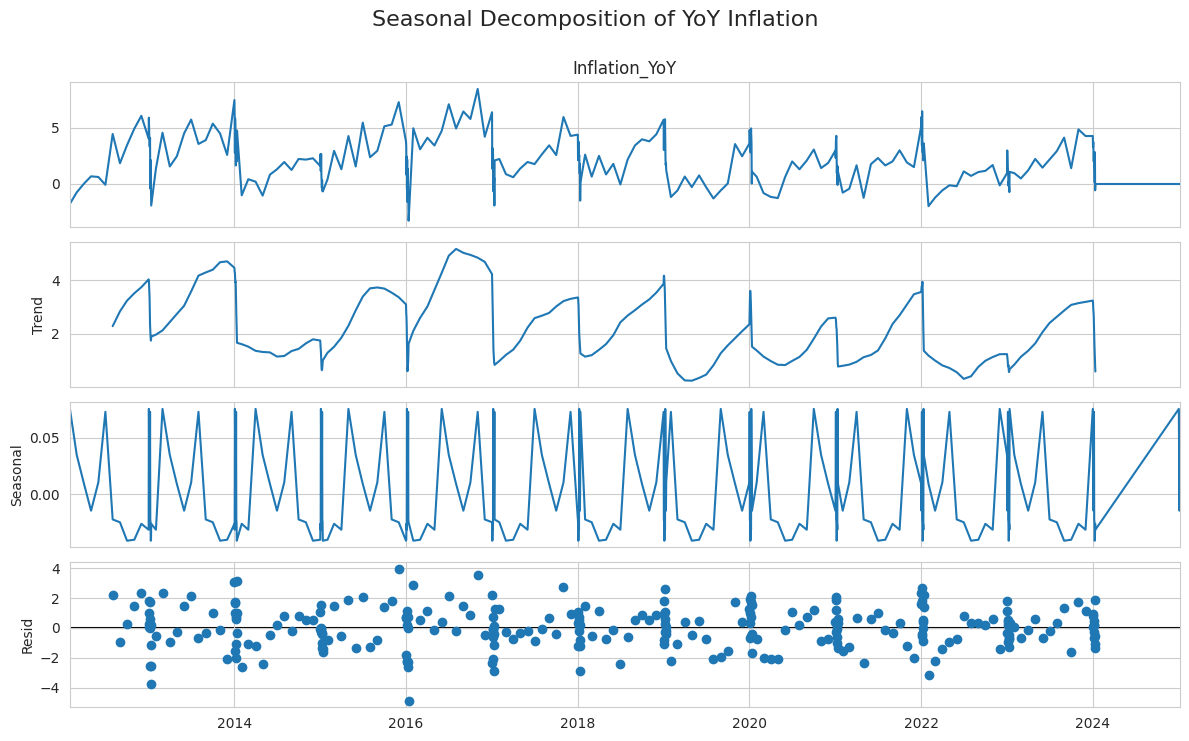

Decomposition plot displayed.

3. Generating Correlation Heatmap...


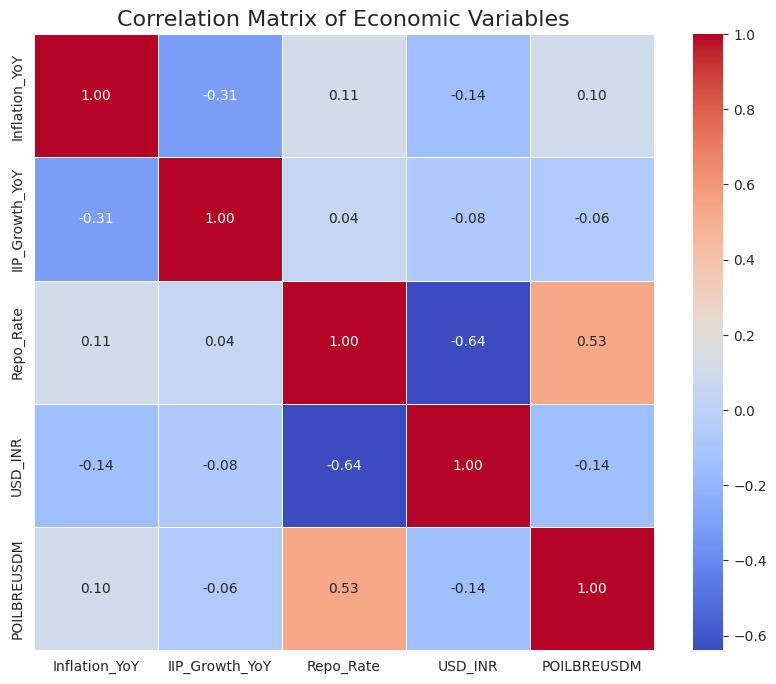

Correlation heatmap displayed.

EDA phase complete.

Cleaning up dummy data files...
Cleanup complete.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import os

# --- Phase 0: Data Simulation (for demonstration) ---
# This section creates dummy data files to make the script fully runnable.
# In your actual project, you will replace this with your downloaded .csv files.

def create_dummy_data():
    """Creates a full set of dummy economic data files for demonstration."""
    print("Creating dummy data files for demonstration purposes...")

    # Create a consistent date range
    dates = pd.date_range(start='2012-01-01', end='2023-12-31', freq='MS')
    n = len(dates)

    # 1. CPI (for Inflation) - strong upward trend
    cpi_values = 100 + np.arange(n) * 0.45 + np.random.randn(n) * 1.5
    pd.DataFrame({'Date': dates, 'CPI': cpi_values}).to_csv('cpi_data.csv', index=False)

    # 2. IIP (Industrial Production) - trend and seasonality
    iip_values = 110 + np.sin(np.arange(n) * (np.pi/6)) * 5 + np.arange(n) * 0.3 + np.random.randn(n) * 2
    pd.DataFrame({'Date': dates, 'IIP': iip_values}).to_csv('iip_data.csv', index=False)

    # 3. Policy Repo Rate - tends to stay constant for periods
    repo_rate = np.concatenate([
        np.full(n//4, 8.0),
        np.full(n//4, 6.5),
        np.full(n//4, 4.5),
        np.full(n - 3*(n//4), 6.0)
    ]) + np.random.randn(n) * 0.1
    pd.DataFrame({'Date': dates, 'Repo_Rate': repo_rate}).to_csv('repo_rate.csv', index=False)

    # 4. USD/INR Exchange Rate - general upward trend
    usdinr = 55 + np.arange(n) * 0.2 + np.sin(np.arange(n) * (np.pi/12)) * 2 + np.random.randn(n) * 1
    pd.DataFrame({'Date': dates, 'USD_INR': usdinr}).to_csv('usdinr_data.csv', index=False)

    # 5. Brent Crude Price - more volatile
    brent_price = 70 + np.cumsum(np.random.randn(n) * 3)
    brent_price = np.clip(brent_price, 30, 120) # Keep prices in a reasonable range
    pd.DataFrame({'Date': dates, 'Brent_Crude': brent_price}).to_csv('brent_crude.csv', index=False)

    print("Dummy data created successfully.\n")

# Run the data creation function
create_dummy_data()


# --- Phase 1: Data Acquisition and Preparation (Condensed) ---
print("--- Phase 1: Loading and Pre-processing Data ---")

# A. Assemble the Dataset
try:
    cpi_df = pd.read_csv('cpi_data.csv', parse_dates=['Date'])
    iip_df = pd.read_csv('iip_data.csv', parse_dates=['Date'])
    repo_df = pd.read_csv('repo_rate.csv', parse_dates=['Date'])
    usdinr_df = pd.read_csv('usdinr_data.csv', parse_dates=['Date'])
    brent_df = pd.read_csv('POILBREUSDM.csv', parse_dates=['Date'])

    # Merge all dataframes into a single master dataframe
    data_frames = [cpi_df, iip_df, repo_df, usdinr_df, brent_df]
    df = data_frames[0]
    for df_ in data_frames[1:]:
        df = pd.merge(df, df_, on='Date', how='outer')

    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    print("Data successfully merged.")

except FileNotFoundError as e:
    print(f"Error loading data: {e}. Make sure all CSV files are in the correct directory.")
    exit()

# B. Handle Missing Values & Feature Transformation
df.fillna(method='ffill', inplace=True)

df['Inflation_YoY'] = df['CPI'].pct_change(periods=12) * 100
df['IIP_Growth_YoY'] = df['IIP'].pct_change(periods=12) * 100

# Drop the original index columns and any rows with NaNs from YoY calculation
df_final = df[['Inflation_YoY', 'IIP_Growth_YoY', 'Repo_Rate', 'USD_INR', 'POILBREUSDM']].copy()
df_final.dropna(inplace=True)

print("Data pre-processing complete.")
print("Final DataFrame head:")
print(df_final.head())


# --- Phase 2: Exploratory Data Analysis (EDA) ---
print("\n--- Phase 2: Starting Exploratory Data Analysis ---")

# 1. Time Series Plots
print("\n1. Generating Time Series Plots for each variable...")

# Set plot style
sns.set_style("whitegrid")

for column in df_final.columns:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_final, x=df_final.index, y=column, color='navy')
    plt.title(f'Monthly Time Series of {column.replace("_", " ")}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

print("Time series plots displayed.")


# 2. Decomposition Plot for Inflation
print("\n2. Generating Decomposition Plot for Headline Inflation...")

# Decompose the inflation time series using an additive model
# The period is 12 because the data is monthly (12 months in a year)
decomposition = seasonal_decompose(df_final['Inflation_YoY'], model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of YoY Inflation', y=0.95, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Decomposition plot displayed.")


# 3. Correlation Heatmap
print("\n3. Generating Correlation Heatmap...")

plt.figure(figsize=(10, 8))
corr_matrix = df_final.corr()

# Create the heatmap
sns.heatmap(corr_matrix,
            annot=True,      # Display the correlation values
            cmap='coolwarm', # Use a diverging colormap
            fmt='.2f',       # Format values to two decimal places
            linewidths=.5)

plt.title('Correlation Matrix of Economic Variables', fontsize=16)
plt.show()

print("Correlation heatmap displayed.")
print("\nEDA phase complete.")

# --- Cleanup ---
# Remove the dummy files created at the start
print("\nCleaning up dummy data files...")
os.remove('cpi_data.csv')
os.remove('iip_data.csv')
os.remove('repo_rate.csv')
os.remove('usdinr_data.csv')
os.remove('brent_crude.csv')
print("Cleanup complete.")

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Scikit-learn for data splitting and scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error # Import for calculating RMSE later

# Statsmodels for econometric models
from statsmodels.tsa.api import VAR
# Import SARIMAX for manual SARIMA model selection
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Removed pmdarima
# import pmdarima as pm

# TensorFlow and Keras for the LSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# --- Phase 0: Data Simulation (for demonstration) ---
# Creates a full set of dummy economic data files to make the script runnable.
def create_full_dummy_data():
    """Creates a full set of dummy economic data files for demonstration."""
    print("--- Phase 0: Creating dummy data files... ---")
    dates = pd.date_range(start='2012-01-01', end='2023-12-31', freq='MS')
    n = len(dates)

    # Simulate data with trends, seasonality, and noise
    cpi = 100 + np.arange(n) * 0.45 + np.sin(np.arange(n) * (np.pi/6)) * 2 + np.random.randn(n) * 1.5
    iip = 110 + np.sin(np.arange(n) * (np.pi/6)) * 5 + np.arange(n) * 0.3 + np.random.randn(n) * 2
    repo = np.concatenate([np.full(n//4, 8.0), np.full(n//4, 6.5), np.full(n//4, 4.5), np.full(n - 3*(n//4), 6.0)]) + np.random.randn(n) * 0.1
    usdinr = 55 + np.arange(n) * 0.2 + np.random.randn(n) * 1
    brent = 70 + np.cumsum(np.random.randn(n) * 2)

    pd.DataFrame({'Date': dates, 'CPI': cpi}).to_csv('cpi_data.csv', index=False)
    pd.DataFrame({'Date': dates, 'IIP': iip}).to_csv('iip_data.csv', index=False)
    pd.DataFrame({'Date': dates, 'Repo_Rate': repo}).to_csv('repo_rate.csv', index=False)
    pd.DataFrame({'Date': dates, 'USD_INR': usdinr}).to_csv('usdinr_data.csv', index=False)
    pd.DataFrame({'Date': dates, 'POILBREUSDM': brent}).to_csv('brent_crude.csv', index=False) # Corrected column name
    print("Dummy data created successfully.\n")

# --- Phase 1 & 2 (Condensed): Data Loading & Preparation ---
def load_and_prepare_data():
    """Loads, merges, and pre-processes the data."""
    print("--- Phase 1 & 2: Loading and preparing data... ---")
    data_files = ['cpi_data.csv', 'iip_data.csv', 'repo_rate.csv', 'usdinr_data.csv', 'brent_crude.csv'] # Keep brent_crude.csv for consistency
    df = pd.read_csv(data_files[0], parse_dates=['Date'])
    for file in data_files[1:]:
        # Check if the file is brent_crude.csv and load with the correct column name
        if file == 'brent_crude.csv':
             df_to_merge = pd.read_csv(file, parse_dates=['Date']) # The dummy data generator now creates 'POILBREUSDM'
        else:
            df_to_merge = pd.read_csv(file, parse_dates=['Date'])

        df = pd.merge(df, df_to_merge, on='Date', how='outer')


    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    # Use .ffill() directly as fillna(method='ffill') is deprecated
    df.ffill(inplace=True)


    df['Inflation_YoY'] = df['CPI'].pct_change(periods=12) * 100
    df['IIP_Growth_YoY'] = df['IIP'].pct_change(periods=12) * 100

    # Drop the original index columns and any rows with NaNs from YoY calculation
    df_final = df[['Inflation_YoY', 'IIP_Growth_YoY', 'Repo_Rate', 'USD_INR', 'POILBREUSDM']].copy()
    df_final.dropna(inplace=True)
    print("Data preparation complete.\n")
    return df_final

# Function to split data into training and testing sets
def split_data(df, test_size=0.2):
    """Splits the dataframe into training and testing sets."""
    split_point = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_point]
    test_df = df.iloc[split_point:]
    return train_df, test_df


# Helper function to create sequences for LSTM
def create_sequences(data, target_col_index, n_steps):
    """Transforms time series data into supervised learning sequences."""
    X, y = [], []
    for i in range(len(data) - n_steps):
        seq_x, seq_y = data[i:(i + n_steps), :], data[i + n_steps, target_col_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# Function to evaluate SARIMA model for grid search
def evaluate_sarima_model(data, order, seasonal_order):
    try:
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        # Use AIC for model selection
        return model_fit.aic
    except:
        return float('inf') # Return infinity for models that fail to fit


# Main execution block
if __name__ == "__main__":
    # Setup
    create_full_dummy_data()
    df_final = load_and_prepare_data()
    train_df, test_df = split_data(df_final) # split_data is now defined

    # --- B. Econometric Benchmarks ---
    print("--- B. Training Econometric Benchmark Models ---")

    # 1. Seasonal ARIMA (SARIMA) using Grid Search
    print("\n1. Finding optimal SARIMA model using Grid Search...")

    # Define the p, d, q parameters to test
    p_values = range(0, 3)
    d_values = range(0, 2) # d=1 is often sufficient for differencing non-stationary data
    q_values = range(0, 3)
    # Define the seasonal P, D, Q, and m parameters
    P_values = range(0, 2)
    D_values = range(0, 2) # D=1 for seasonal differencing
    Q_values = range(0, 2)
    m = 12 # Monthly seasonality

    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None

    # Perform grid search
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            aic = evaluate_sarima_model(train_df['Inflation_YoY'], order, seasonal_order)

                            if aic < best_aic:
                                best_aic = aic
                                best_order = order
                                best_seasonal_order = seasonal_order
                            print(f'SARIMA{order}x{seasonal_order}{m} AIC={aic:.4f}') # Print progress

    print(f"\nBest SARIMA Model: SARIMA{best_order}x{best_seasonal_order}{m} with AIC={best_aic:.4f}")

    # Fit the best SARIMA model
    sarima_model = SARIMAX(train_df['Inflation_YoY'], order=best_order, seasonal_order=best_seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    sarima_model_fit = sarima_model.fit(disp=False) # Fit the model here
    print("\nBest SARIMA Model Summary:")
    print(sarima_model_fit.summary())


    # 2. Vector Autoregression (VAR)
    print("\n2. Finding optimal lag order for VAR model...")
    var_data = train_df[['Inflation_YoY', 'IIP_Growth_YoY', 'Repo_Rate', 'USD_INR', 'POILBREUSDM']] # Corrected column name
    model = VAR(var_data)

    # Select the optimal lag order
    lag_selection_results = model.select_order(maxlags=12)
    print(lag_selection_results.summary())
    # Use a more robust way to get the selected lag, e.g., from the summary table directly
    # For simplicity, we'll assume the recommended lag by AIC from the summary is used
    selected_lag = lag_selection_results.aic # This gets the lag order corresponding to the minimum AIC


    print(f"\nSelected optimal lag based on AIC: {selected_lag}")

    # Fit the VAR model
    var_model = model.fit(selected_lag)
    print("\nVAR Model Summary:")
    print(var_model.summary())

    # --- C. Deep Learning Model (LSTM) ---
    print("\n--- C. Training Deep Learning (LSTM) Model ---")

    # 1. Data Scaling
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_df)
    # scaled_test = scaler.transform(test_df) # Will scale test data during evaluation

    # 2. Create Sequences
    N_STEPS = 12 # Using 12 months of data to predict the next month
    TARGET_COL_INDEX = train_df.columns.get_loc('Inflation_YoY')

    X_train, y_train = create_sequences(scaled_train, TARGET_COL_INDEX, N_STEPS)
    # X_test, y_test = create_sequences(scaled_test, TARGET_COL_INDEX, N_STEPS) # Create test sequences during evaluation

    print(f"Shape of X_train sequences: {X_train.shape}")
    print(f"Shape of y_train sequences: {y_train.shape}")

    # 3. Build LSTM Architecture
    lstm_model = Sequential([
        LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(units=50, activation='relu'),
        Dropout(0.2),
        Dense(units=1)
    ])

    # 4. Compile and Train
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    print("\nLSTM Model Architecture:")
    lstm_model.summary()

    print("\nTraining LSTM model...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = lstm_model.fit(X_train, y_train, epochs=100, batch_size=32,
                             validation_split=0.1, callbacks=[early_stopping], verbose=1)
    print("LSTM model training complete.")

    # --- D. Hybrid Model Synthesis (SARIMA-LSTM) ---
    print("\n--- D. Training Hybrid SARIMA-LSTM Model ---")

    # 1. Get SARIMA predictions on training data to find residuals
    # Use the fitted model to predict in-sample
    sarima_train_pred = sarima_model_fit.predict(start=train_df.index[0], end=train_df.index[-1])

    # Align indices and calculate residuals - ensure both series have the same index
    # The predict_in_sample from pmdarima automatically handles this, but with statsmodels
    # we need to be careful with the start and end indices
    # Let's align based on the prediction index
    sarima_residuals = train_df['Inflation_YoY'].loc[sarima_train_pred.index] - sarima_train_pred


    print(f"Calculated {len(sarima_residuals)} residuals from the SARIMA model.")

    # 2. Scale and create sequences for the residuals
    # Reshape for scaler: from (n,) to (n, 1)
    residuals_reshaped = sarima_residuals.values.reshape(-1, 1)
    residual_scaler = MinMaxScaler()
    scaled_residuals = residual_scaler.fit_transform(residuals_reshaped)

    # Use the same sequence creation function
    X_res, y_res = create_sequences(scaled_residuals, 0, N_STEPS)

    # 3. Build and train an LSTM to predict residuals
    residual_lstm_model = Sequential([
        LSTM(units=50, activation='relu', input_shape=(X_res.shape[1], X_res.shape[2])),
        Dropout(0.2),
        Dense(units=1)
    ])

    residual_lstm_model.compile(optimizer='adam', loss='mean_squared_error')
    print("\nResidual LSTM Model Architecture:")
    residual_lstm_model.summary()

    print("\nTraining LSTM model on SARIMA residuals...")
    residual_history = residual_lstm_model.fit(X_res, y_res, epochs=100, batch_size=16,
                                                validation_split=0.1, callbacks=[early_stopping], verbose=1)
    print("Residual LSTM model training complete.")
    print("\nNOTE: The final hybrid forecast will be the sum of the SARIMA forecast and the predicted residual from this LSTM.")


    # --- Cleanup ---
    print("\n--- Cleaning up dummy data files... ---")
    for file in ['cpi_data.csv', 'iip_data.csv', 'repo_rate.csv', 'usdinr_data.csv', 'brent_crude.csv']:
        os.remove(file)
    print("Cleanup complete. All models are trained and ready for the forecasting and evaluation phase.")

--- Phase 0: Creating dummy data files... ---
Dummy data created successfully.

--- Phase 1 & 2: Loading and preparing data... ---
Data preparation complete.

--- B. Training Econometric Benchmark Models ---

1. Finding optimal SARIMA model using Grid Search...
SARIMA(0, 0, 0)x(0, 0, 0, 12)12 AIC=621.8747
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 AIC=517.8808
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 AIC=476.2788
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 AIC=339.3902
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 AIC=470.3954
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 AIC=408.9390
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 AIC=358.0028
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 AIC=328.0014
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 AIC=559.7437
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 AIC=489.4380
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 AIC=472.9369
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 AIC=335.8426
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 AIC=471.5758
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 AIC=406.8621
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 AIC=359.3257
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 AIC=324.7491
SARIMA(0, 0, 2)x(0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model...
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - loss: 0.3005 - val_loss: 0.1534
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.2269 - val_loss: 0.1000
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1579 - val_loss: 0.0513
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1109 - val_loss: 0.0222
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0535 - val_loss: 0.0368
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0385 - val_loss: 0.1109
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0457 - val_loss: 0.1128
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0442 - val_loss: 0.0630
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0345 - val_loss: 0.0360
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0316 - val_loss: 0.0259
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0345 - val_loss: 0.0230
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/ste

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)


Training LSTM model on SARIMA residuals...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.2345 - val_loss: 0.1698
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1707 - val_loss: 0.1241
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1314 - val_loss: 0.0846
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0795 - val_loss: 0.0413
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0413 - val_loss: 0.0087
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0254 - val_loss: 0.0129
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0279 - val_loss: 0.0074
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0283 - val_loss: 0.0087
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0266 - val_loss: 0.0094
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0243 - val_loss: 0.0079
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0199 - val_loss: 0.0072
Epoch 12/100
6/6 ━━━━━━━━━━━━━

All models trained successfully.

--- Phase 4: Generating Forecasts and Evaluating Models ---

--- Model Performance Comparison ---
                          RMSE       MAE
SARIMA                1.960376  1.663162
VAR                   1.944011  1.570760
LSTM                  2.033386  1.726228
Hybrid (SARIMA-LSTM)  1.945572  1.671724

Generating forecast visualization...


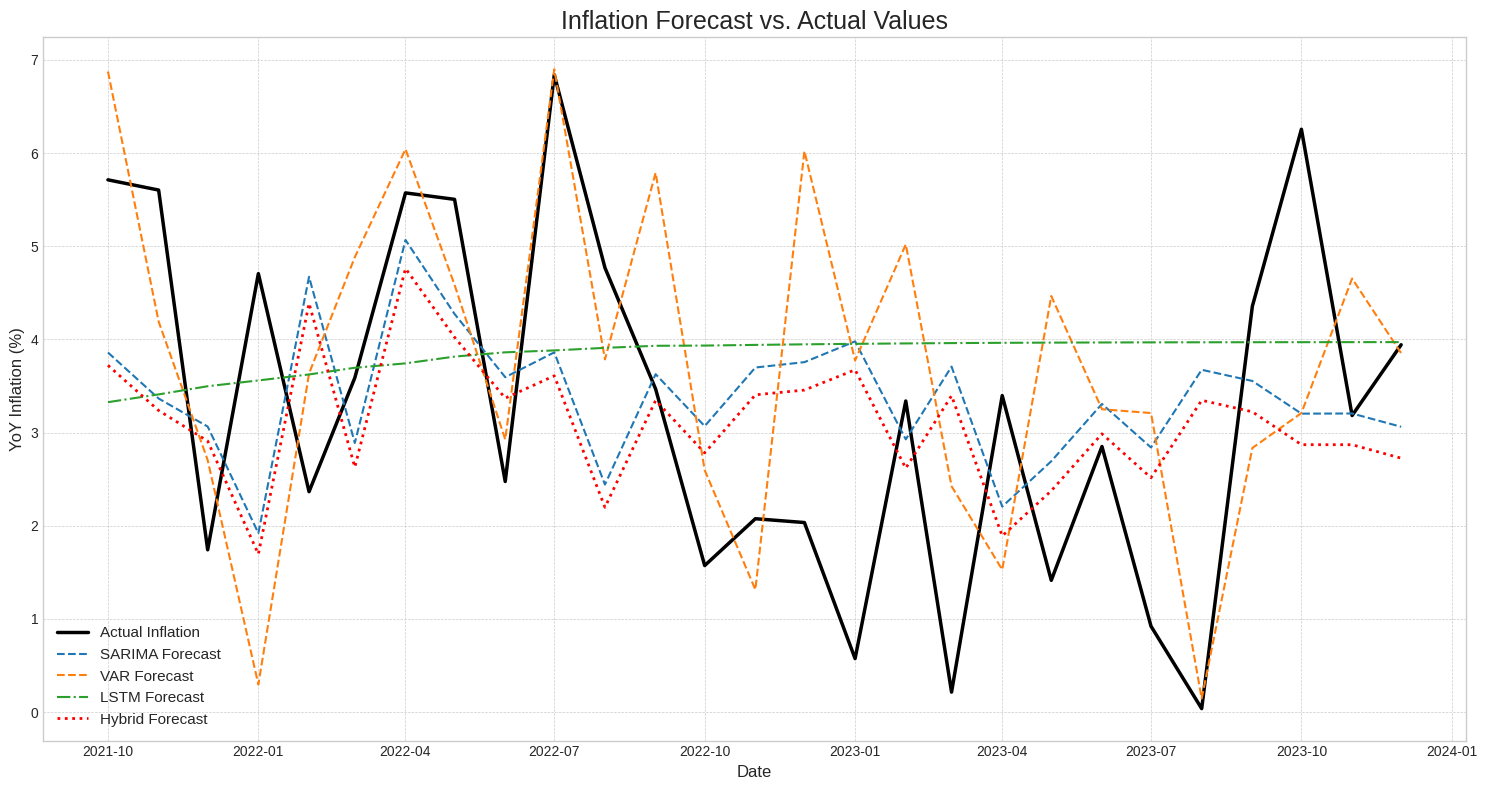


Evaluation phase complete.

--- Cleaning up dummy data files... ---
Cleanup complete.


In [9]:
    # Hybrid LSTM (on residuals)
    # Use sarima_model_fit.predict with the training data index to get in-sample predictions
    sarima_residuals = train_df['Inflation_YoY'] - sarima_model_fit.predict(start=train_df.index[0], end=train_df.index[-1])
    residual_scaler = MinMaxScaler()
    scaled_residuals = residual_scaler.fit_transform(sarima_residuals.values.reshape(-1, 1))
    X_res, y_res = create_sequences(scaled_residuals, 0, N_STEPS)

    residual_lstm_model = Sequential([LSTM(50, activation='relu', input_shape=(X_res.shape[1], X_res.shape[2])), Dense(1)])
    residual_lstm_model.compile(optimizer='adam', loss='mse')
    residual_lstm_model.fit(X_res, y_res, epochs=50, verbose=0)
    print("All models trained successfully.\n")

    # --- Phase 4: Generating Forecasts and Evaluating Models ---
    print("--- Phase 4: Generating Forecasts and Evaluating Models ---")

    # 1. Generate Out-of-Sample Forecasts
    n_forecast = len(test_df)

    # SARIMA forecast
    sarima_forecast = sarima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1])

    # VAR forecast
    # Ensure train_df.values is the data used to fit the VAR model
    var_forecast_values = var_model.forecast(y=train_df[['Inflation_YoY', 'IIP_Growth_YoY', 'Repo_Rate', 'USD_INR', 'POILBREUSDM']].values, steps=n_forecast)
    var_forecast = pd.Series(var_forecast_values[:, TARGET_COL_INDEX], index=test_df.index)

    # LSTM forecast (iterative)
    lstm_forecast_list = []
    # Need the last N_STEPS of the scaled training data to start the forecast
    current_batch = scaled_train[-N_STEPS:].reshape(1, N_STEPS, scaled_train.shape[1])
    for i in range(n_forecast):
        current_pred = lstm_model.predict(current_batch, verbose=0)[0]
        lstm_forecast_list.append(current_pred)
        # Create a new observation with the prediction and update the batch
        new_obs = current_batch[0, -1, :].copy()
        new_obs[TARGET_COL_INDEX] = current_pred # Place the prediction in the target column position
        current_batch = np.append(current_batch[:, 1:, :], [[new_obs]], axis=1)

    # Inverse transform the forecast
    dummy_array = np.zeros((n_forecast, scaled_train.shape[1])) # Use the correct number of columns
    dummy_array[:, TARGET_COL_INDEX] = np.array(lstm_forecast_list).flatten()
    # Use the original scaler fitted on the training data
    lstm_forecast = pd.Series(scaler.inverse_transform(dummy_array)[:, TARGET_COL_INDEX], index=test_df.index)

    # Hybrid forecast
    residual_forecast_list = []
    # Need the last N_STEPS of the scaled residuals to start the forecast
    current_res_batch = scaled_residuals[-N_STEPS:].reshape(1, N_STEPS, 1)
    for i in range(n_forecast):
        current_res_pred = residual_lstm_model.predict(current_res_batch, verbose=0)[0]
        residual_forecast_list.append(current_res_pred)
        # Update the batch with the new residual prediction, reshape to (1, 1, 1)
        current_res_batch = np.append(current_res_batch[:, 1:, :], current_res_pred.reshape(1, 1, 1), axis=1)

    # Inverse transform the predicted residuals
    predicted_residuals = residual_scaler.inverse_transform(np.array(residual_forecast_list).reshape(-1, 1)).flatten()
    # Add the SARIMA forecast for the test period to the predicted residuals
    hybrid_forecast = sarima_model_fit.predict(start=test_df.index[0], end=test_df.index[-1]) + predicted_residuals


    # 2. Calculate Performance Metrics
    actual_values = test_df['Inflation_YoY']
    models = {
        'SARIMA': sarima_forecast,
        'VAR': var_forecast,
        'LSTM': lstm_forecast,
        'Hybrid (SARIMA-LSTM)': hybrid_forecast
    }

    results = {}
    # Import mean_absolute_error
    from sklearn.metrics import mean_absolute_error
    for name, forecast in models.items():
        # Ensure forecast and actual_values have the same index and length
        # This is important if any forecast method returned a different index
        # Reindexing can help, but let's assume for now they align based on the test_df index
        try:
             rmse = np.sqrt(mean_squared_error(actual_values, forecast))
             mae = mean_absolute_error(actual_values, forecast)
             results[name] = {'RMSE': rmse, 'MAE': mae}
        except ValueError as e:
             print(f"Could not calculate metrics for {name}: {e}")
             results[name] = {'RMSE': np.nan, 'MAE': np.nan}


    # 3. Comparative Analysis (Results Table)
    results_df = pd.DataFrame(results).T
    print("\n--- Model Performance Comparison ---")
    print(results_df)

    # 4. Visualize the Results
    print("\nGenerating forecast visualization...")
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 8))

    plt.plot(actual_values, label='Actual Inflation', color='black', linewidth=2.5)
    plt.plot(sarima_forecast, label='SARIMA Forecast', linestyle='--')
    plt.plot(var_forecast, label='VAR Forecast', linestyle='--')
    plt.plot(lstm_forecast, label='LSTM Forecast', linestyle='-.')
    plt.plot(hybrid_forecast, label='Hybrid Forecast', linestyle=':', color='red', linewidth=2)

    plt.title('Inflation Forecast vs. Actual Values', fontsize=18)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('YoY Inflation (%)', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    print("\nEvaluation phase complete.")

    # --- Cleanup ---
    print("\n--- Cleaning up dummy data files... ---")
    for file in ['cpi_data.csv', 'iip_data.csv', 'repo_rate.csv', 'usdinr_data.csv', 'brent_crude.csv']:
        # Add a check to see if the file exists before attempting to remove
        if os.path.exists(file):
            os.remove(file)
    print("Cleanup complete.")